### Imports

In [1]:
%matplotlib widget
%cd ../../..
import logging
logging.basicConfig(level=logging.INFO)
import os
import re

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from skimage.measure import label
from skimage.metrics import mean_squared_error, normalized_root_mse

from BabelBrain.GPUFunctions.GPULabel import LabelImage
from BabelBrain.GPUFunctions.GPUResample import Resample

c:\Users\alanc\miniconda3\envs\bbl_dev\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\alanc\OneDrive\Documents\GitHub\BabelBrain


### GPU Initialization

In [ ]:

# GPUBackend = 'CUDA'
GPUBackend = 'OpenCL'
# GPUBackend = 'Metal' # Metal version isn't ready yet
gpu_name = 'Apple M1 Max'

Resample.InitResample(gpu_name, GPUBackend=GPUBackend)
LabelImage.InitLabel(gpu_name,GPUBackend=GPUBackend)

Number of CUDA devices found: 1
Number of CUDA devices found: 1


### Load Input Data

In [ ]:
scan_type = 'CT'
folder_path = '/Users/acoreas/Documents/unit_test_data/SDR_0p31/'
base_name = folder_path + scan_type
fname = base_name + '.nii.gz'
nifti = nibabel.load(fname)
data = np.ascontiguousarray(nifti.get_fdata())

### Determine Output Data Resolution

In [4]:
# Set desired spatial step
resolution_level = {
    '0': 0.919,    # 200 kHz,   6 PPW
    '1': 0.613,    # 200 kHz,   9 PPW
    '2': 0.459,    # 200 kHz,  12 PPW
    '3': 0.306,    # 600 kHz,   6 PPW
    '4': 0.204,    # 600 kHz,   9 PPW
    '5': 0.153,    # 600 kHz,  12 PPW
    '6': 0.184,    # 1000 kHz,  6 PPW
    '7': 0.123,    # 1000 kHz,  9 PPW
    '8': 0.092,    # 1000 kHz, 12 PPW
}
spatial_step = np.full(3,resolution_level['0'])
# spatial_step = np.asarray(nifti.header.get_zooms())/2
spatial_step_text = re.sub("\.","_",str(spatial_step[0]))

# Calculate new affine
zooms = np.asarray(nifti.header.get_zooms())
print(f"Original zooms: {zooms}")
print(f"New zooms: {spatial_step}")
new_x = int(nifti.shape[0]/(spatial_step[0]/zooms[0]))
new_y = int(nifti.shape[1]/(spatial_step[1]/zooms[1]))
new_z = int(nifti.shape[2]/(spatial_step[2]/zooms[2]))
affine_upscaled = affines.rescale_affine(nifti.affine.copy(),
                                         nifti.shape,
                                         spatial_step,
                                         (new_x,new_y,new_z))

# Output dimensions
output_data = np.zeros((new_x,new_y,new_z),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,affine_upscaled)
print(f"Output Dimensions: {output_data.shape}")
print(f"Output Size: {output_data.size}")

Original zooms: [0.44921902 0.449219   0.62494195]
New zooms: [0.919 0.919 0.919]
Output Dimensions: (250, 323, 217)
Output Size: 17522750


### Run Resample Step

In [ ]:
# Select a resample method
# resample_method = 'CPU' # Truth method, accurate but takes longer especially for higher resolutions
resample_method = 'GPU' # Much faster, but can have slight deviations from truth. Acceptable for purposes of this test.
print(f"Resampling via {resample_method}")

# Set resample order and mode (default is 3 and 'constant')
order = 0 # 0  or 3
mode = 'constant' #'nearest'

if resample_method == 'CPU':
    # Reload file if it was created already, otherwise generate and save file
    resampled_fname = base_name + f"_resampled_{resample_method}_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(resampled_fname):
        print('Reloading file')
        resampled_nifti = nibabel.load(resampled_fname)
        resampled_data = resampled_nifti.get_fdata()
    else:
        print('Generating file')
        resampled_nifti = processing.resample_from_to(nifti,output_nifti,mode=mode,order=order,cval=data.min()) # Truth method
        print('Saving file')
        nibabel.save(resampled_nifti,resampled_fname)
        print('Collecting data')
        resampled_data=resampled_nifti.get_fdata()
elif resample_method == 'GPU':
    # Generating file is typically faster than reloading a saved file
    print('Generating file')
    resampled_nifti = Resample.ResampleFromTo(nifti,output_nifti,mode=mode,order=order,cval=data.min(),GPUBackend=GPUBackend)
    resampled_data = resampled_nifti.get_fdata()

INFO:root:
Starting Resample


Resampling via GPU
Generating file


### Prepare Data

In [6]:
# Check input data is contiguous
if not resampled_data.flags.contiguous:
    print("Changing input data to be a contiguous array")
    resampled_data = np.ascontiguousarray(resampled_data)
    
HUCapThreshold = 2100.0
HUThreshold = 300.0
resampled_data[resampled_data>HUCapThreshold] = HUCapThreshold
fct = resampled_data > HUThreshold
nfct = fct > 0.5

### Run Label Step

In [7]:
with CodeTimer("GPU Label", unit="s"):
    data_label_gpu = LabelImage.LabelImage(nfct, GPUBackend=GPUBackend)

with CodeTimer("CPU Label", unit="s"):
    print(f"Starting Label")
    label_truth_fname = folder_path + f"label_CPU_{scan_type}_resampled_{resample_method}_mode_{mode}_order_{order}_spatial_step_{spatial_step_text}.nii.gz"
    if os.path.exists(label_truth_fname):
        print("Reloading CPU file")
        data_label_cpu = nibabel.load(label_truth_fname).get_fdata()
    else:
        print('Generating CPU file')
        data_label_cpu = label(nfct)
        nifti_label_cpu = nibabel.Nifti1Image(data_label_cpu.astype(np.float32),affine_upscaled)
        print('Saving CPU file')
        nibabel.save(nifti_label_cpu,label_truth_fname)

# Ensure arrays are same size and dtype
if data_label_gpu.size != data_label_cpu.size:
    print(f"Array sizes don't match: {data_label_gpu.size} vs {data_label_cpu.size}")
if data_label_gpu.size == 0:
    print("Arrays are empty")
if data_label_gpu.dtype != data_label_cpu.dtype:
    print("Arrays have different dtypes")
    data_label_gpu.astype(data_label_cpu.dtype)

INFO:root:
Starting Label


Code block 'GPU Label' took: 0.04426 s
Starting Label
Reloading CPU file
Code block 'CPU Label' took: 0.09301 s
Arrays have different dtypes


### Plot Data

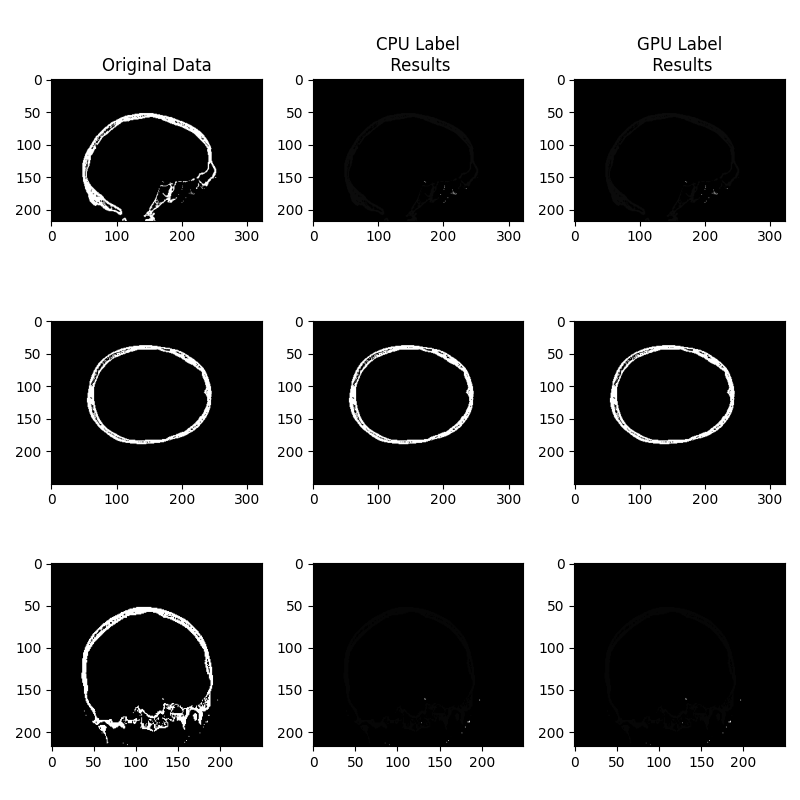

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

slice_num = resampled_data.shape[0]//2
axs[0,0].set_title("Original Data")
axs[0,0].imshow(np.rot90(nfct[slice_num,:,:]), cmap='gray')
axs[0,1].set_title("CPU Label\n Results")
axs[0,1].imshow(np.rot90(data_label_cpu[slice_num,:,:]), cmap='gray')
axs[0,2].set_title("GPU Label\n Results")
axs[0,2].imshow(np.rot90(data_label_gpu[slice_num,:,:]), cmap='gray')

slice_num = resampled_data.shape[2]//2
axs[1,0].imshow(nfct[:,:,slice_num], cmap='gray')
axs[1,1].imshow(data_label_cpu[:,:,slice_num], cmap='gray')
axs[1,2].imshow(data_label_gpu[:,:,slice_num], cmap='gray')

slice_num = resampled_data.shape[1]//2
axs[2,0].imshow(np.rot90(nfct[:,slice_num,:]), cmap='gray')
axs[2,1].imshow(np.rot90(data_label_cpu[:,slice_num,:]), cmap='gray')
axs[2,2].imshow(np.rot90(data_label_gpu[:,slice_num,:]), cmap='gray')

# Adjust plots
plt.subplots_adjust(top=0.8,bottom=0.2,wspace=0.1, hspace=0)
plt.tight_layout()

### Check Output Data Matches Truth Data

In [9]:
data_match = np.all(data_label_cpu==data_label_gpu)
print(f"Data matches? {data_match}")

if not data_match:
    # DICE coefficient calculation
    matches = abs(data_label_gpu - data_label_cpu) < 1e-6
    matches_count = len(matches[matches==True])
    dice_coeff = 2 * matches_count / (data_label_cpu.size + data_label_gpu.size)
    print(f"Dice Coefficient: {dice_coeff}")

    # Plot difference images
    diffs = abs(data_label_gpu - data_label_cpu)

    fig, axs = plt.subplots(3, 1, figsize=(4, 12))

    slice_num = diffs.shape[0]//2
    axs[0].imshow(np.rot90(diffs[slice_num,:,:]), cmap='gray')

    slice_num = diffs.shape[2]//2
    axs[1].imshow(diffs[:,:,slice_num], cmap='gray')

    slice_num = diffs.shape[1]//2
    axs[2].imshow(np.rot90(diffs[:,slice_num,:]), cmap='gray')

    plt.tight_layout()

    # Get difference histograms
    hist,bins = np.histogram(diffs)
    print(f"Difference Histogram")
    for bin in range(len(bins)-1):
        print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")

    # Mean square error calculation
    mse = mean_squared_error(data_label_cpu,data_label_gpu)
    print(f"Mean square error: {mse}")

    # Normalized root mean square error calculation
    nrmse = normalized_root_mse(data_label_cpu,data_label_gpu,normalization='min-max')
    print(f"Normalized root mean square error: {nrmse}")

Data matches? True
